<a href="https://colab.research.google.com/github/emilianodesu/RLA2/blob/main/cartpole/cart-pole-dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![View on GitHub](https://img.shields.io/badge/GitHub-Repo-blue?logo=github)](https://github.com/emilianodesu/RLA2)

## Cloning repository to execute in Google Colab

In [1]:
import os
def detect_colab() -> bool:
    """
    Detect whether the runtime is Google Colab.

    Returns:
        bool: True if running in Google Colab; False otherwise.
    """
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

IN_COLAB = detect_colab()
BASE_PATH = '/content/' if IN_COLAB else './'

print(f"IN_COLAB: {IN_COLAB}")
print(f"BASE_PATH: {BASE_PATH}")

if IN_COLAB:
    # Clone Github repo
    if not os.path.exists(f"{BASE_PATH}/RLA2"):
        !git clone https://github.com/emilianodesu/RLA2.git
    os.chdir(f"{BASE_PATH}/RLA2")
    print(f"Current directory: {os.getcwd()}")

IN_COLAB: True
BASE_PATH: /content/
Cloning into 'RLA2'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 167 (delta 44), reused 110 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (167/167), 7.13 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Filtering content: 100% (32/32), 516.60 MiB | 93.41 MiB/s, done.
Current directory: /content/RLA2


# Deep Q-Network on classic control

This notebook will explore the implementation of a DQN from Stable Baselines3 on a classic-control environment.

### What you will learn?
* Using Deep Q-Network from Stable Baseline3
* Training on cart pole environment

## Setup
Install necessary dependencies.

In [12]:
!pip install gymnasium
!pip install "stable-baselines3[extra]"
!pip install moviepy
!sudo apt-get update
!apt-get install -y xvfb ffmpeg freeglut3-dev

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 128 kB in 1s (94.6 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (so

Import libraries

In [4]:
# Import necessary libraries and modules
import os
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import base64
from IPython import display as ipythondisplay
import torch

print(f"{gym.__version__=}")
print(f"{stable_baselines3.__version__=}")

gym.__version__='1.2.1'
stable_baselines3.__version__='2.7.0'


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Configure Environment

In [5]:
# Set up a fake display for rendering videos in the cloud environment
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

## Callbacks and directory setup

In [6]:
# Callback for saving the model at regular intervals
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        super().__init__(verbose)
        self.save_interval = save_interval
        self.save_path = save_path

    def _on_step(self) -> bool:
        if self.num_timesteps % self.save_interval == 0:
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')
            self.model.save(save_file)
            if self.verbose > 0:
                print(f'Saving model to {save_file}.zip')
        return True

In [7]:
# Creating directories for storing logs and models
if IN_COLAB:
    log_dir = "/content/RLA2/cartpole/dqn/logs/"
    models_dir = "/content/RLA2/cartpole/dqn/models/"
    videos_dir = "/content/RLA2/cartpole/dqn/videos/"
else:
    log_dir = "dqn/logs/"
    models_dir = "dqn/models/"
    videos_dir = "dqn/videos"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(videos_dir, exist_ok=True)

## Cart pole environment

In [8]:
env_id = "CartPole-v1"
def make_env():
    env = gym.make(env_id)
    env = Monitor(env, log_dir)
    return env

env = DummyVecEnv([make_env])

## DQN Model

In [9]:
# We are defining a network with two hidden layers of 64 neurons each.
policy_kwargs = dict(net_arch=[256, 256], activation_fn=torch.nn.ReLU)

# Use MlpPolicy and CartPole-specific hyperparameters
model = DQN(
    "MlpPolicy",
    verbose=1,
    env=env,
    learning_rate=1e-4,               # Smaller LR = more stable updates
    buffer_size=100_000,             # Large replay buffer for stability
    learning_starts=10_000,          # Start training after collecting good variety
    batch_size=64,                   # Typical for small state spaces
    tau=1.0,                         # Hard update for target network (DQN standard)
    gamma=0.99,                      # CartPole reward discount
    train_freq=4,                    # Learn every 4 steps
    gradient_steps=1,                # One gradient step per training iteration
    target_update_interval=1_000,    # Update target network every 1k steps
    exploration_fraction=0.1,        # Fraction of total steps for linear epsilon decay
    exploration_final_eps=0.01,      # Final epsilon for greedy policy
    max_grad_norm=10,               # Gradient clipping
    policy_kwargs=policy_kwargs # Use our custom network
)

Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Train the model

In [10]:
# Set up the callback for saving models
save_interval = 100_000
save_callback = SaveOnIntervalCallback(save_interval=save_interval, save_path=models_dir)

# ### CHANGE 4: Reduce total timesteps ###
total_timesteps = 1_000_000

# Train the DQN agent
model.learn(total_timesteps=total_timesteps, callback=save_callback)

# Save the final trained model
final_model_path = os.path.join(models_dir, f'model_{total_timesteps}')
model.save(final_model_path)

Streaming output truncated to the last 5000 lines.
| rollout/            |          |
|    ep_len_mean      | 152      |
|    ep_rew_mean      | 152      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 5368     |
|    fps              | 538      |
|    time_elapsed     | 761      |
|    total_timesteps  | 409897   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 99974    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | 157      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 5372     |
|    fps              | 538      |
|    time_elapsed     | 763      |
|    total_timesteps  | 410652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|   

## Performance evaluation

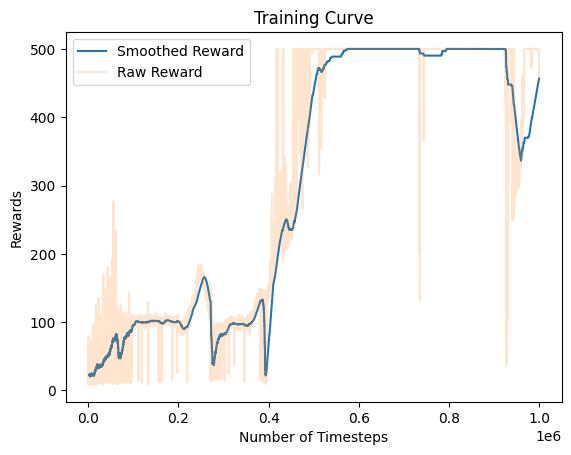

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
def plot_results(log_folder: str):
    """
    Plots the training curve from the Monitor log file.
    :param log_folder: the save directory of the Monitor logs
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')

    # Smooth the curve
    y_smooth = np.convolve(y, np.ones(100)/100, mode='valid')
    x_smooth = x[len(x) - len(y_smooth):]

    fig = plt.figure("Training Curve")
    plt.plot(x_smooth, y_smooth, label="Smoothed Reward")
    plt.plot(x, y, alpha=0.2, label="Raw Reward")
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title("Training Curve")
    plt.legend()
    plt.show()

# Call the function after training to see the learning curve
plot_results(log_dir)

## Video Recording and Display Functions

In [13]:
# Functions to record and show videos of the agent playing

def show_videos(video_path="", prefix=""):
    html = []
    for mp4 in Path(video_path).glob(f"{prefix}*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            f'''<video alt="{mp4.name}" autoplay loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
             </video>'''
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

# ### MODIFICATION ###: Updated video folder and env_id
def record_video(env_id, model, video_length=500, prefix="", video_folder="dqn/videos"):
    os.makedirs(video_folder, exist_ok=True)
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )
    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True) # Use deterministic for evaluation
        obs, _, _, _ = eval_env.step(action)
    eval_env.close()

## Record and Display Videos at Different Training Stages

In [19]:
# Functions for analyzing the trained models

# Function to get the identifiers of saved models
def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)  # Listing files in the models directory
    model_files = [f for f in files if f.startswith('model_')]  # Filtering out model files
    identifiers = [f.split('_')[1] for f in model_files]  # Extracting identifiers from file names
    return identifiers

# Function to find key identifiers (earliest, middle, final)
def find_key_identifiers(identifiers):
    identifiers.sort()  # Sorting identifiers
    earliest = identifiers[0]  # Earliest identifier
    final = identifiers[-1]  # Final identifier
    middle = identifiers[len(identifiers) // 2]  # Middle identifier
    return earliest, middle, final

# Function to view videos of the models at different training stages
def view(models_dir, video_folder="dqn/videos"):
    identifiers = get_model_identifiers(models_dir)  # Getting model identifiers
    print(identifiers)
    earliest, middle, final = find_key_identifiers(identifiers)  # Finding key identifiers

    # Recording and displaying videos at the beginning, middle, and end of training
    for stage, identifier in zip(["beginning", "middle", "end"], [earliest, middle, final]):
        model_path = os.path.join(models_dir, f'model_{identifier}')  # Forming the model path
        model = DQN.load(model_path)  # Loading the model
        record_video("CartPole-v1", model, video_length=5000, prefix=f'dqn-cartpole-{stage}', video_folder=video_folder)  # Recording video
        show_videos(prefix=f'dqn-cartpole-{stage}', video_path=video_folder)  # Showing videos

In [20]:
view(models_dir=models_dir, video_folder=videos_dir)  # Calling the view function

['1000000.zip', '800000.zip', '500000.zip', '600000.zip', '700000.zip', '900000.zip', '200000.zip', '300000.zip', '400000.zip', '100000.zip']
Saving video to /content/RLA2/cartpole/dqn/videos/dqn-cartpole-beginning-step-0-to-step-5000.mp4
Moviepy - Building video /content/RLA2/cartpole/dqn/videos/dqn-cartpole-beginning-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/cartpole/dqn/videos/dqn-cartpole-beginning-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/RLA2/cartpole/dqn/videos/dqn-cartpole-beginning-step-0-to-step-5000.mp4


Saving video to /content/RLA2/cartpole/dqn/videos/dqn-cartpole-middle-step-0-to-step-5000.mp4
Moviepy - Building video /content/RLA2/cartpole/dqn/videos/dqn-cartpole-middle-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/cartpole/dqn/videos/dqn-cartpole-middle-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/RLA2/cartpole/dqn/videos/dqn-cartpole-middle-step-0-to-step-5000.mp4


Saving video to /content/RLA2/cartpole/dqn/videos/dqn-cartpole-end-step-0-to-step-5000.mp4
Moviepy - Building video /content/RLA2/cartpole/dqn/videos/dqn-cartpole-end-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/cartpole/dqn/videos/dqn-cartpole-end-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/RLA2/cartpole/dqn/videos/dqn-cartpole-end-step-0-to-step-5000.mp4
